SNR: 9.0 dB -> BER: 3.073864e-01
SNR: 10.0 dB -> BER: 2.742188e-01
SNR: 10.7 dB -> BER: 2.505343e-01
SNR: 11.5 dB -> BER: 2.216172e-01
SNR: 12.6 dB -> BER: 1.825668e-01
SNR: 13.5 dB -> BER: 1.528596e-01
SNR: 14.5 dB -> BER: 1.165308e-01
SNR: 15.4 dB -> BER: 9.036045e-02
SNR: 16.4 dB -> BER: 6.681686e-02
SNR: 17.3 dB -> BER: 4.656004e-02
SNR: 18.5 dB -> BER: 2.828859e-02
SNR: 19.3 dB -> BER: 1.949686e-02
SNR: 20.4 dB -> BER: 1.114798e-02
SNR: 21.3 dB -> BER: 6.460429e-03
SNR: 22.1 dB -> BER: 3.961803e-03
SNR: 23.1 dB -> BER: 2.109273e-03
SNR: 23.5 dB -> BER: 1.926652e-03


C:\Users\mshif\AppData\Local\Temp\ipykernel_12332\3668810097.py:81: RuntimeWarning: overflow encountered in exp
  return np.exp(a * x**3 + b * x**2 + c * x + d)


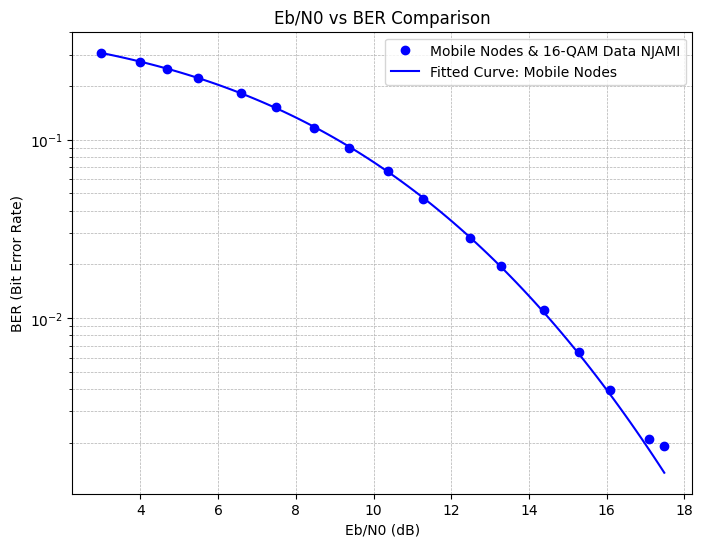

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit



# Define function to read binary files
def read_binary_file(file_path):
    """Reads a binary file and returns its content as bytes."""
    with open(file_path, "rb") as f:
        return f.read()

# Define function to count bit errors
def count_bit_errors(tx_packet, rx_packet):
    """Counts the number of bit errors between two equal-length packets."""
    return sum(bin(tx_byte ^ rx_byte).count('1') for tx_byte, rx_byte in zip(tx_packet, rx_packet))

# Define function to calculate BER
def calculate_ber(tx_file, rx_file, packet_size=40):
    # Read the transmitted packet (40 bytes)
    tx_data = read_binary_file(tx_file)
    
    if len(tx_data) != packet_size:
        raise ValueError("TX.bin must contain exactly one 40-byte packet.")

    # Read the received packets
    rx_data = read_binary_file(rx_file)
    
    # Determine the number of received packets
    num_packets = len(rx_data) // packet_size
    if num_packets == 0:
        raise ValueError(f"{rx_file} does not contain any complete packets.")

    # Compare each received packet with the TX packet
    total_bit_errors = 0
    total_bits = num_packets * packet_size * 8  # Each byte = 8 bits

    for i in range(num_packets):
        rx_packet = rx_data[i * packet_size: (i + 1) * packet_size]
        bit_errors = count_bit_errors(tx_data, rx_packet)
        total_bit_errors += bit_errors

    # Calculate BER
    ber = total_bit_errors / total_bits if total_bits > 0 else 0
    return ber

# Define file paths
tx_file_path = r"C:\Users\mshif\1st_set_weeks\TX.bin"
rx_folder_path = r"C:\Users\mshif\1st_set_weeks"

# List of SNR values from file names
snr_values = [9.0, 10.0, 10.7, 11.5, 12.6, 13.5, 14.5, 15.4, 16.4, 17.3, 18.5, 19.3, 20.4, 21.3, 22.1, 23.1, 23.5]

# Compute BER for each file
ber_values = []
for snr in snr_values:
    rx_file_path = os.path.join(rx_folder_path, f"RX_{snr}.bin")
    ber = calculate_ber(tx_file_path, rx_file_path)
    ber_values.append(ber)
    print(f"SNR: {snr} dB -> BER: {ber:.6e}")

# Convert SNR to Eb/N0 (For 16-QAM, Eb/N0 = SNR - 6.02)
ebno_real = np.array(snr_values) - 6.02
ber_real = np.array(ber_values)

# Extracted SIONNA Data (Updated)
ebno_sionna = np.array([
    -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 
    11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0
])
ber_sionna = np.array([
    3.2020e-01, 2.9449e-01, 2.6703e-01, 2.3971e-01, 2.1229e-01, 1.8567e-01, 
    1.6141e-01, 1.3841e-01, 1.1610e-01, 9.4959e-02, 7.4864e-02, 5.6541e-02, 
    4.0149e-02, 2.7052e-02, 1.6759e-02, 9.6346e-03, 4.7852e-03, 2.1362e-03, 
    7.8288e-04, 2.2990e-04, 5.6966e-05, 1.0037e-05, 1.0642e-06, 5.6966e-08 
])

# Define a polynomial fit function (logarithmic scale for BER)
def poly_fit(x, a, b, c, d):
    return np.exp(a * x**3 + b * x**2 + c * x + d)

# Curve fitting for real data
params_real, _ = curve_fit(poly_fit, ebno_real, ber_real, p0=[-0.1, 0.1, -0.1, -5])
ebno_fit_real = np.linspace(min(ebno_real), max(ebno_real), 100)
ber_fit_real = poly_fit(ebno_fit_real, *params_real)

# Curve fitting for SIONNA data
params_sionna, _ = curve_fit(poly_fit, ebno_sionna, ber_sionna, p0=[-0.1, 0.1, -0.1, -5])
ebno_fit_sionna = np.linspace(min(ebno_sionna), max(ebno_sionna), 100)
ber_fit_sionna = poly_fit(ebno_fit_sionna, *params_sionna)

# Plot the data and fits
plt.figure(figsize=(8, 6))

# Plot SIONNA data with connected lines
#plt.semilogy(ebno_sionna, ber_sionna, 'ro-', label="SIONNA, Ray Tracing & 16-QAM Data")

# Plot Mobile Nodes data with fitted curve
plt.semilogy(ebno_real, ber_real, 'bo', label="Mobile Nodes & 16-QAM Data NJAMI")
plt.semilogy(ebno_fit_real, ber_fit_real, 'b-', label="Fitted Curve: Mobile Nodes")

plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER (Bit Error Rate)")
plt.title("Eb/N0 vs BER Comparison")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()

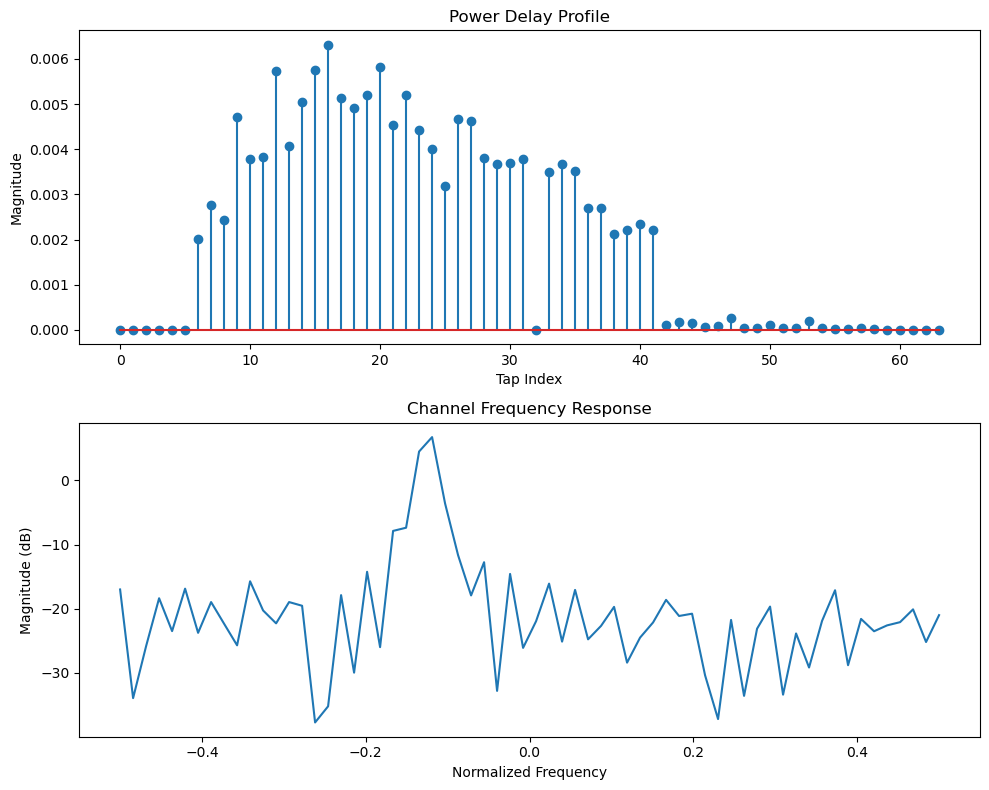

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parse provided taps into complex array
taps_str = "#[(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (-0.0220568,-0.0391134) (-0.0512598,-0.0119286) (-0.0415808,0.0264926) (-0.0396449,0.0561657) (0.0313231,0.0530589) (0.0609767,0.0100747) (0.0529806,-0.054137) (0.00254568,-0.0636983) (-0.0434844,-0.0562465) (-0.0757662,0.00378052) (-0.0455788,0.0651239) (0.0119253,0.0707331) (0.0595199,0.0370338) (0.0717819,-0.00747198) (0.0318358,-0.0693594) (-0.0187622,-0.0646178) (-0.0649287,-0.0313469) (-0.0645692,0.0160629) (-0.025097,0.0580649) (0.0256058,0.0503934) (0.0646176,0.0224414) (0.0615073,-0.0291496) (0.0147035,-0.0598484) (-0.030905,-0.0521991) (-0.0576132,-0.0196473) (-0.0525674,0.0318706) (0,0) (0.0293055,0.0514074) (0.059883,0.00982822) (0.0476157,-0.035299) (0.00274764,-0.051982) (-0.0308681,-0.0416791) (-0.045369,-0.00749685) (-0.0363912,0.0299692) (-0.000486604,0.0484614) (0.033262,0.0333565) (0.010388,-0.00128144) (0.0121255,-0.00533179) (0.00176426,-0.0123956) (-0.00521973,-0.00550126) (-0.00886444,-0.000670747) (-0.00455509,0.0155201) (-0.00272737,0.00676056) (0.00604592,0.00394468) (0.00903804,-0.0043333) (0.00575237,-0.00188762) (0.00423932,-0.00602368) (-0.00933035,-0.0103972) (-0.00434457,-0.00370349) (-0.00424633,-0.000244591) (-0.000307525,0.00428429) (-0.000135022,0.00646244) (0.00328168,0.000945389) (0,0) (0,0) (0,0) (0,0) (0,0)]"
taps_clean = taps_str[2:-1].replace('(', '').replace(')', '').split()
h = np.array([complex(*map(float, t.split(','))) for t in taps_clean])

# Power Delay Profile
pdp = np.abs(h)**2

# Frequency Response (64-point FFT)
H = np.fft.fftshift(np.fft.fft(h, 64))
freq = np.linspace(-0.5, 0.5, 64)  # Normalized frequency

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# PDP Plot
ax1.stem(pdp)
ax1.set_title("Power Delay Profile")
ax1.set_xlabel("Tap Index")
ax1.set_ylabel("Magnitude")

# Frequency Response
ax2.plot(freq, 20*np.log10(np.abs(H) + 1e-10))
ax2.set_title("Channel Frequency Response")
ax2.set_xlabel("Normalized Frequency")
ax2.set_ylabel("Magnitude (dB)")
plt.tight_layout()
plt.show()

k |  Re{Ĥ[k]}        Im{Ĥ[k]}
--+----------------+----------------
 0| +nan +nan
 1| +nan +nan
 2| +nan +nan
 3| +nan +nan
 4| +nan +nan
 5| +nan +nan
 6| +0.02205680 +0.03911340
 7| +0.05125980 +0.01192860
 8| +0.04158080 -0.02649260
 9| +0.03964490 -0.05616570
10| +0.03132310 +0.05305890
11| +0.06097670 +0.01007470
12| -0.05298060 +0.05413700
13| -0.00254568 +0.06369830
14| +0.04348440 +0.05624650
15| -0.07576620 +0.00378052
16| +0.04557880 -0.06512390
17| +0.01192530 +0.07073310
18| +0.05951990 +0.03703380
19| +0.07178190 -0.00747198
20| +0.03183580 -0.06935940
21| -0.01876220 -0.06461780
22| +0.06492870 +0.03134690
23| +0.06456920 -0.01606290
24| +0.02509700 -0.05806490
25| -0.02560580 -0.05039340
26| -0.06461760 -0.02244140
27| +0.06150730 -0.02914960
28| -0.01470350 +0.05984840
29| +0.03090500 +0.05219910
30| -0.05761320 -0.01964730
31| +0.05256740 -0.03187060
32| +nan +nan
33| +0.02930550 +0.05140740
34| -0.05988300 -0.00982822
35| +0.04761570 -0.03529900
36| +0.00274764 -0.05

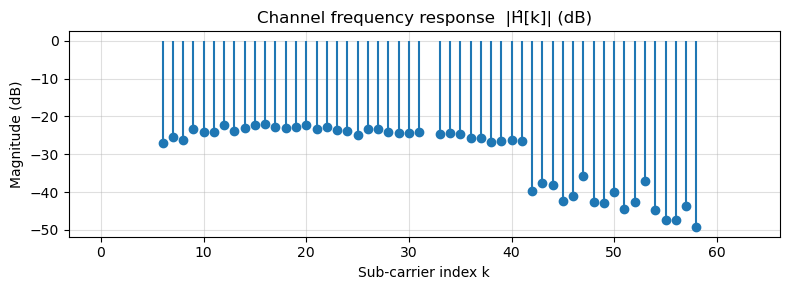

In [3]:
# -------------------------------------------------------------
# Channel frequency response for a 64-sub-carrier OFDM preamble
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# 1. -------- Known LTS pattern (frequency domain) -------------
X_lts = np.array([
     0,  0,  0,  0,  0,  0, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1,
    -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1,
     0,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,
     1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  0,  0,  0,  0,  0
], dtype=np.int8)

# 2. -------- Received LTS (frequency domain) -------------------
# Paste the 64 complex numbers exactly as printed by GNU Radio:
Y_tuples = [
    (0,0),(0,0),(0,0),(0,0),(0,0),(0,0),
    (-0.0220568,-0.0391134),(-0.0512598,-0.0119286),
    (-0.0415808,0.0264926),(-0.0396449,0.0561657),
     (0.0313231,0.0530589),(0.0609767,0.0100747),
     (0.0529806,-0.054137),(0.00254568,-0.0636983),
    (-0.0434844,-0.0562465),(-0.0757662,0.00378052),
    (-0.0455788,0.0651239),(0.0119253,0.0707331),
     (0.0595199,0.0370338),(0.0717819,-0.00747198),
     (0.0318358,-0.0693594),(-0.0187622,-0.0646178),
    (-0.0649287,-0.0313469),(-0.0645692,0.0160629),
    (-0.025097,0.0580649),(0.0256058,0.0503934),
     (0.0646176,0.0224414),(0.0615073,-0.0291496),
     (0.0147035,-0.0598484),(-0.030905,-0.0521991),
    (-0.0576132,-0.0196473),(-0.0525674,0.0318706),
     (0,0),(0.0293055,0.0514074),(0.059883,0.00982822),
     (0.0476157,-0.035299),(0.00274764,-0.051982),
    (-0.0308681,-0.0416791),(-0.045369,-0.00749685),
    (-0.0363912,0.0299692),(-0.000486604,0.0484614),
     (0.033262,0.0333565),(0.010388,-0.00128144),
     (0.0121255,-0.00533179),(0.00176426,-0.0123956),
    (-0.00521973,-0.00550126),(-0.00886444,-0.000670747),
    (-0.00455509,0.0155201),(-0.00272737,0.00676056),
     (0.00604592,0.00394468),(0.00903804,-0.0043333),
     (0.00575237,-0.00188762),(0.00423932,-0.00602368),
    (-0.00933035,-0.0103972),(-0.00434457,-0.00370349),
    (-0.00424633,-0.000244591),(-0.000307525,0.00428429),
    (-0.000135022,0.00646244),(0.00328168,0.000945389),
     (0,0),(0,0),(0,0),(0,0),(0,0)
]

Y_lts = np.array([complex(r,i) for r,i in Y_tuples], dtype=np.complex64)

# Sanity check
assert len(X_lts) == len(Y_lts) == 64, "Sequences must be length-64"

# 3. -------- Least-squares channel estimate -------------------
H_hat = np.empty(64, dtype=np.complex64)
# Where X_lts == 0 (guard/DC), we cannot estimate => set to NaN
mask = X_lts != 0
H_hat[mask]  = Y_lts[mask] / X_lts[mask]
H_hat[~mask] = np.nan + 1j*np.nan

# 4. -------- Print per-sub-carrier CFR ------------------------
print("k |  Re{Ĥ[k]}        Im{Ĥ[k]}")
print("--+----------------+----------------")
for k, h in enumerate(H_hat):
    print(f"{k:2d}| {h.real:+.8f} {h.imag:+.8f}")

# 5. -------- Quick magnitude plot -----------------------------
plt.figure(figsize=(8,3))
plt.stem(np.arange(64), 20*np.log10(np.abs(H_hat)), basefmt=" ")
plt.title("Channel frequency response  |Ĥ[k]| (dB)")
plt.xlabel("Sub-carrier index k")
plt.ylabel("Magnitude (dB)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\mshif\AppData\Local\Temp\ipykernel_18292\2536683185.py:39: RuntimeWarning: invalid value encountered in divide
  H_np = np.where(S_np != 0, Y_np / S_np, complex(0, 0))


Channel Frequency Response for Each Subcarrier:
Subcarrier 0: 0j
Subcarrier 1: 0j
Subcarrier 2: 0j
Subcarrier 3: 0j
Subcarrier 4: 0j
Subcarrier 5: 0j
Subcarrier 6: (0.0220568+0.0391134j)
Subcarrier 7: (0.0512598+0.0119286j)
Subcarrier 8: (0.0415808-0.0264926j)
Subcarrier 9: (0.0396449-0.0561657j)
Subcarrier 10: (0.0313231+0.0530589j)
Subcarrier 11: (0.0609767+0.0100747j)
Subcarrier 12: (-0.0529806+0.054137j)
Subcarrier 13: (-0.00254568+0.0636983j)
Subcarrier 14: (0.0434844+0.0562465j)
Subcarrier 15: (-0.0757662+0.00378052j)
Subcarrier 16: (0.0455788-0.0651239j)
Subcarrier 17: (0.0119253+0.0707331j)
Subcarrier 18: (0.0595199+0.0370338j)
Subcarrier 19: (0.0717819-0.00747198j)
Subcarrier 20: (0.0318358-0.0693594j)
Subcarrier 21: (-0.0187622-0.0646178j)
Subcarrier 22: (0.0649287+0.0313469j)
Subcarrier 23: (0.0645692-0.0160629j)
Subcarrier 24: (0.025097-0.0580649j)
Subcarrier 25: (-0.0256058-0.0503934j)
Subcarrier 26: (-0.0646176-0.0224414j)
Subcarrier 27: (0.0615073-0.0291496j)
Subcarrier 

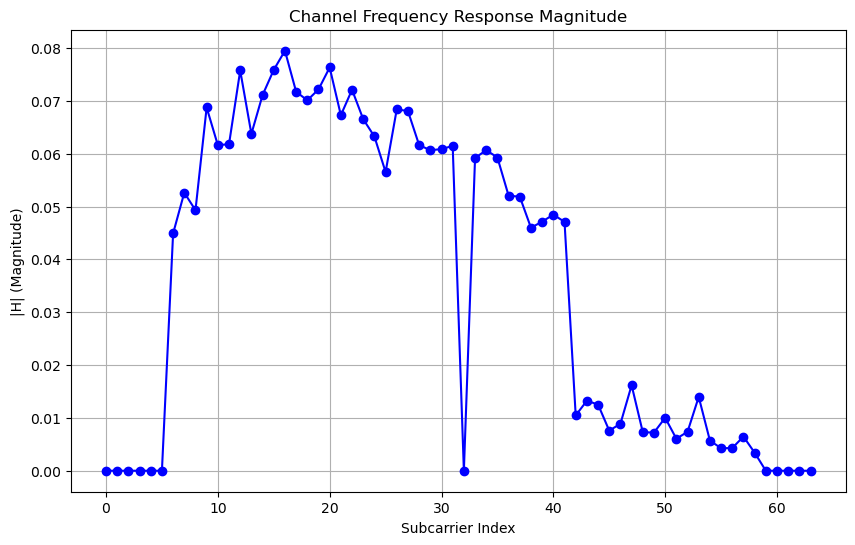

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the known sequence S
S = [
    0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1,
    -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 0, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1,
    1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 0, 0, 0, 0, 0
]

# Define the received sequence Y
Y = [
    (0,0), (0,0), (0,0), (0,0), (0,0), (0,0), (-0.0220568,-0.0391134), 
    (-0.0512598,-0.0119286), (-0.0415808,0.0264926), (-0.0396449,0.0561657), 
    (0.0313231,0.0530589), (0.0609767,0.0100747), (0.0529806,-0.054137), 
    (0.00254568,-0.0636983), (-0.0434844,-0.0562465), (-0.0757662,0.00378052), 
    (-0.0455788,0.0651239), (0.0119253,0.0707331), (0.0595199,0.0370338), 
    (0.0717819,-0.00747198), (0.0318358,-0.0693594), (-0.0187622,-0.0646178), 
    (-0.0649287,-0.0313469), (-0.0645692,0.0160629), (-0.025097,0.0580649), 
    (0.0256058,0.0503934), (0.0646176,0.0224414), (0.0615073,-0.0291496), 
    (0.0147035,-0.0598484), (-0.030905,-0.0521991), (-0.0576132,-0.0196473), 
    (-0.0525674,0.0318706), (0,0), (0.0293055,0.0514074), (0.059883,0.00982822), 
    (0.0476157,-0.035299), (0.00274764,-0.051982), (-0.0308681,-0.0416791), 
    (-0.045369,-0.00749685), (-0.0363912,0.0299692), (-0.000486604,0.0484614), 
    (0.033262,0.0333565), (0.010388,-0.00128144), (0.0121255,-0.00533179), 
    (0.00176426,-0.0123956), (-0.00521973,-0.00550126), (-0.00886444,-0.000670747), 
    (-0.00455509,0.0155201), (-0.00272737,0.00676056), (0.00604592,0.00394468), 
    (0.00903804,-0.0043333), (0.00575237,-0.00188762), (0.00423932,-0.00602368), 
    (-0.00933035,-0.0103972), (-0.00434457,-0.00370349), (-0.00424633,-0.000244591), 
    (-0.000307525,0.00428429), (-0.000135022,0.00646244), (0.00328168,0.000945389), 
    (0,0), (0,0), (0,0), (0,0), (0,0)
]

# Convert to numpy arrays
S_np = np.array(S)
Y_np = np.array([complex(y[0], y[1]) for y in Y])

# Compute channel frequency response H
H_np = np.where(S_np != 0, Y_np / S_np, complex(0, 0))

# Print H for each subcarrier index
print("Channel Frequency Response for Each Subcarrier:")
for i in range(len(H_np)):
    print(f"Subcarrier {i}: {H_np[i]}")

# Plot magnitude of H
plt.figure(figsize=(10, 6))
plt.plot(np.abs(H_np), marker='o', linestyle='-', color='b')
plt.xlabel('Subcarrier Index')
plt.ylabel('|H| (Magnitude)')
plt.title('Channel Frequency Response Magnitude')
plt.grid(True)
plt.show()

Subcarrier Index | Channel Frequency Response (Real, Imag)
---------------------------------------------------------
 0 |  -0.071888 +  -0.034755j
 1 |  -0.112211 +   0.109424j
 2 |   0.055049 +   0.005458j
 3 |  -0.002451 +   0.139980j
 4 |   0.048887 +  -0.030555j
 5 |   0.073382 +   0.002588j
 6 |  -0.021052 +  -0.101096j
 7 |  -0.007025 +   0.037284j
 8 |   0.028004 +  -0.052444j
 9 |  -0.035830 +   0.069336j
10 |   0.072239 +  -0.092137j
11 |  -0.054246 +   0.068875j
12 |  -0.062444 +  -0.066657j
13 |  -0.021847 +   0.020888j
14 |   0.012995 +  -0.004560j
15 |   0.006357 +   0.081421j
16 |   0.019508 +  -0.007447j
17 |   0.017546 +   0.067514j
18 |   0.046347 +  -0.092865j
19 |   0.014931 +   0.015248j
20 |  -0.021252 +  -0.060420j
21 |  -0.026985 +   0.021904j
22 |   0.021143 +  -0.077431j
23 |  -0.104699 +   0.091684j
24 |   0.028009 +  -0.022978j
25 |   0.048881 +   0.067277j
26 |   0.003112 +  -0.066561j
27 |   0.001426 +   0.074028j
28 |  -0.003623 +  -0.078380j
29 |  -0.0746

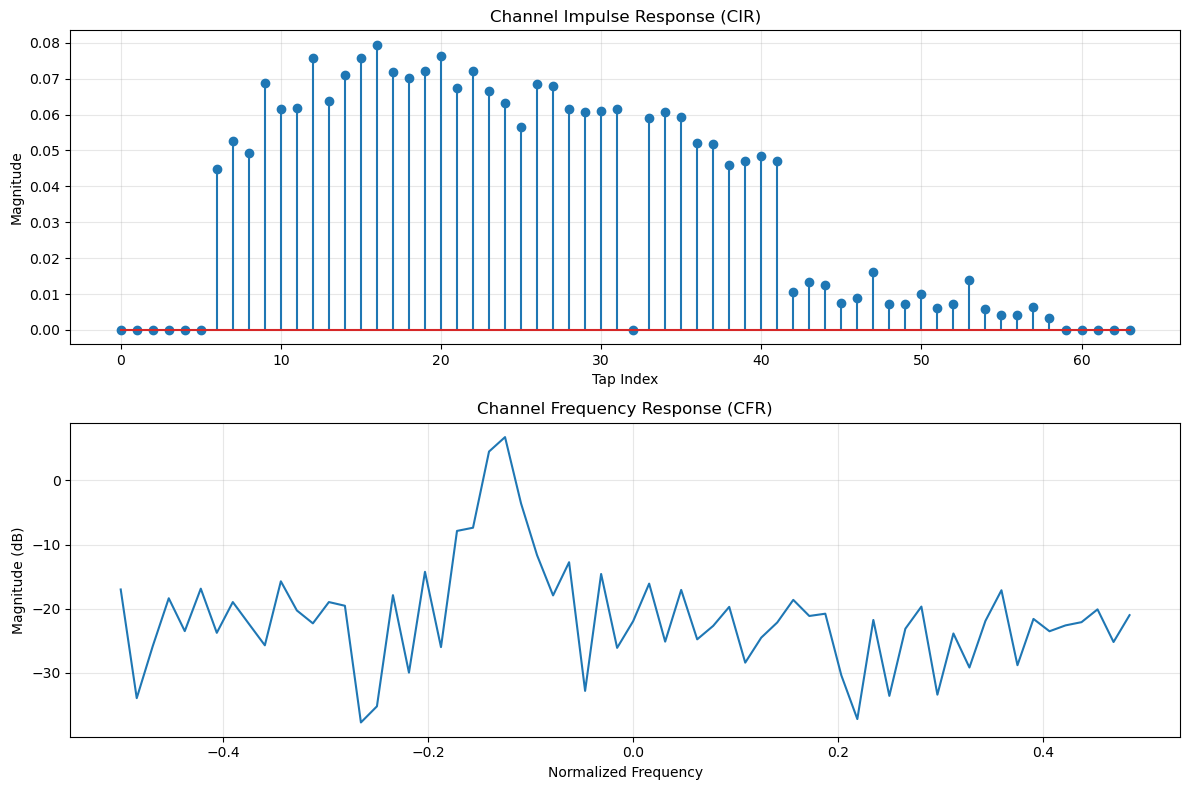

In [6]:
import numpy as np

# Known sync sequence (time domain)
known_sync = np.array([
    0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1,
    -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1,
    0, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1,
    1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 0, 0, 0, 0, 0
], dtype=complex)

# Received sequence (time domain)
received_str = "[(0,0) (0,0) (0,0) (0,0) (0,0) (0,0) (-0.0220568,-0.0391134) (-0.0512598,-0.0119286) (-0.0415808,0.0264926) (-0.0396449,0.0561657) (0.0313231,0.0530589) (0.0609767,0.0100747) (0.0529806,-0.054137) (0.00254568,-0.0636983) (-0.0434844,-0.0562465) (-0.0757662,0.00378052) (-0.0455788,0.0651239) (0.0119253,0.0707331) (0.0595199,0.0370338) (0.0717819,-0.00747198) (0.0318358,-0.0693594) (-0.0187622,-0.0646178) (-0.0649287,-0.0313469) (-0.0645692,0.0160629) (-0.025097,0.0580649) (0.0256058,0.0503934) (0.0646176,0.0224414) (0.0615073,-0.0291496) (0.0147035,-0.0598484) (-0.030905,-0.0521991) (-0.0576132,-0.0196473) (-0.0525674,0.0318706) (0,0) (0.0293055,0.0514074) (0.059883,0.00982822) (0.0476157,-0.035299) (0.00274764,-0.051982) (-0.0308681,-0.0416791) (-0.045369,-0.00749685) (-0.0363912,0.0299692) (-0.000486604,0.0484614) (0.033262,0.0333565) (0.010388,-0.00128144) (0.0121255,-0.00533179) (0.00176426,-0.0123956) (-0.00521973,-0.00550126) (-0.00886444,-0.000670747) (-0.00455509,0.0155201) (-0.00272737,0.00676056) (0.00604592,0.00394468) (0.00903804,-0.0043333) (0.00575237,-0.00188762) (0.00423932,-0.00602368) (-0.00933035,-0.0103972) (-0.00434457,-0.00370349) (-0.00424633,-0.000244591) (-0.000307525,0.00428429) (-0.000135022,0.00646244) (0.00328168,0.000945389) (0,0) (0,0) (0,0) (0,0) (0,0)]"

# Parse received sequence
received_clean = received_str[1:-1].replace('(', '').replace(')', '').split()
received = np.zeros(64, dtype=complex)
for i, token in enumerate(received_clean):
    real_str, imag_str = token.split(',')
    received[i] = float(real_str) + 1j * float(imag_str)

# Channel impulse response (CIR) from GNU Radio
cir = np.array([
    0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j,
    -0.0220568-0.0391134j, -0.0512598-0.0119286j, -0.0415808+0.0264926j, -0.0396449+0.0561657j,
    0.0313231+0.0530589j, 0.0609767+0.0100747j, 0.0529806-0.054137j, 0.00254568-0.0636983j,
    -0.0434844-0.0562465j, -0.0757662+0.00378052j, -0.0455788+0.0651239j, 0.0119253+0.0707331j,
    0.0595199+0.0370338j, 0.0717819-0.00747198j, 0.0318358-0.0693594j, -0.0187622-0.0646178j,
    -0.0649287-0.0313469j, -0.0645692+0.0160629j, -0.025097+0.0580649j, 0.0256058+0.0503934j,
    0.0646176+0.0224414j, 0.0615073-0.0291496j, 0.0147035-0.0598484j, -0.030905-0.0521991j,
    -0.0576132-0.0196473j, -0.0525674+0.0318706j, 0+0j, 0.0293055+0.0514074j,
    0.059883+0.00982822j, 0.0476157-0.035299j, 0.00274764-0.051982j, -0.0308681-0.0416791j,
    -0.045369-0.00749685j, -0.0363912+0.0299692j, -0.000486604+0.0484614j, 0.033262+0.0333565j,
    0.010388-0.00128144j, 0.0121255-0.00533179j, 0.00176426-0.0123956j, -0.00521973-0.00550126j,
    -0.00886444-0.000670747j, -0.00455509+0.0155201j, -0.00272737+0.00676056j, 0.00604592+0.00394468j,
    0.00903804-0.0043333j, 0.00575237-0.00188762j, 0.00423932-0.00602368j, -0.00933035-0.0103972j,
    -0.00434457-0.00370349j, -0.00424633-0.000244591j, -0.000307525+0.00428429j, -0.000135022+0.00646244j,
    0.00328168+0.000945389j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j
])

# Compute Channel Frequency Response (CFR)
H = np.fft.fft(cir, 64)

# Print CFR for all 64 subcarriers
print("Subcarrier Index | Channel Frequency Response (Real, Imag)")
print("---------------------------------------------------------")
for k in range(64):
    print(f"{k:2d} | {H[k].real:10.6f} + {H[k].imag:10.6f}j")

# Optional: Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Time-domain CIR
plt.subplot(211)
plt.stem(np.abs(cir))
plt.title("Channel Impulse Response (CIR)")
plt.xlabel("Tap Index")
plt.ylabel("Magnitude")
plt.grid(True, alpha=0.3)

# Frequency-domain CFR
plt.subplot(212)
plt.plot(np.fft.fftshift(np.fft.fftfreq(64)), np.fft.fftshift(20*np.log10(np.abs(H) + 1e-10)))
plt.title("Channel Frequency Response (CFR)")
plt.xlabel("Normalized Frequency")
plt.ylabel("Magnitude (dB)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()